### We begin with boilerplate:

In [1]:
import os
import sys
from collections import defaultdict
import numpy as np
from joblib import Parallel, delayed
import multiprocessing

# point at library; I need some lessons on doing good PYTHONPATHs:
REPO_DIR = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(REPO_DIR, 'lib'))

import society
import society.strategic
import society.basic
import society.lateral
from outbreak import Outbreak
from disease import Covid
from population.covid import PersonCovid
from population.networks.household_workplace import HouseholdWorkplacePopulation
import config

In [2]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 5]

In [3]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.ERROR)

## 1. Recall the baseline config of all the simulations:

In [4]:
config.print_baseline_config()

DAILY_TEST_CAPACITY_PER_HEAD 0.0075
DAYS_BEFORE_INFECTIOUS 4
DAYS_INFECTIOUS_TO_SYMPTOMS 2
DAYS_OF_SYMPTOMS 5
DURATION_OF_ISOLATION 10
MEAN_NETWORK_SIZE 9.0
PROB_APPLY_FOR_TEST_IF_SYMPTOMS 0.75
PROB_GET_TEST_IF_TRACED 0.75
PROB_INFECT_IF_TOGETHER_ON_A_DAY 0.025
PROB_ISOLATE_IF_SYMPTOMS 0.75
PROB_ISOLATE_IF_TESTPOS 0.3
PROB_ISOLATE_IF_TRACED 0.3
PROB_NON_C19_SYMPTOMS_PER_DAY 0.01
PROB_SYMPTOMATIC 0.6
PROB_TEST_IF_REQUESTED 1
PROB_TRACING_GIVEN_CONTACT 0.6000000000000001
SIMULATOR_PERIODS_PER_DAY 1
TEST_DAYS_ELAPSED 1
_PROPORTION_OF_INFECTED_WHO_GET_TESTED 0.44999999999999996
_TARGET_R0 1.4


## 2. Now set the scale of the simulations:

We'll simulate across several small towns/villages, each of size:

In [5]:
population_size = 5600 * 2

Next, decide how many infected people to seed as infected in each simulation:

In [6]:
nSeed = int(population_size / 80) # setting infection rate to 1/80
nSeed

140

The number of days of the epidemic to simulate:

In [7]:
nDays = 121

Number of times to repeat each simulated setting:

In [8]:
nReps = 12

Now lets figure out how to batch this:

In [9]:
batch_size = multiprocessing.cpu_count() - 2

n_batches = (nReps - 1) // batch_size + 1
n_batches

2

## 3. Now lets configure the scenarios to be repeatedly simulated and compared:

OK, now it's time to set up our grid of configs to try (these will override the list of config at the top of this notebook).

This bit of coding is always somewhat ad-hoc and is where a lot of the experimentation takes place:

In [10]:
valencies = [30, 100]  # [20, 25]

In [11]:
c_valencies = [11]  # [7, 11, 15]

In [12]:
valency_frequencies = [3]

In [13]:
population_config = dict(MEAN_NETWORK_SIZE = 4)

In [14]:
society_config = dict()
valency_config = dict()

Create a dictionary of the 'societies' that interest us, by named keys:

In [15]:
societies={'UK': (society.UKSociety, society_config),
#            'DoubleTester': (society.ContactDoubleTestingSociety, society_config),
#            'ValencyIsolator_NoQ': (society.HighValencyIsolator, valency_config)
          }

We can use the box below if we want to add some two-track testers to our list of 'societies':

We will use the box below to add some lateral testers to our simulation:

In [16]:
def get_lateral_tester(thresh, lat_pcr_ratio, retest_positives):
    attribute_overrides = valency_config.copy()
    attribute_overrides.update(dict(VALENCY_TEST_FREQUENCY_DAYS = 3, LATERAL_TO_PCR_RATIO = lat_pcr_ratio, RETEST_POSITIVE_CASES=retest_positives))
    return society.lateral.LateralFlowUK, attribute_overrides

In [17]:
societies.update({f'LateralFlow_{rp}_{lpr}_{thresh}': get_lateral_tester(thresh, lpr, rp) 
                  for thresh in valencies 
#                   for freq in valency_frequencies
                  for lpr in [0, 10, 20]
                  for rp in [True]}
                )

At a background level, we mway want to repeat the whole list of societies with some variations on the underlying config:

In [18]:
# we'll look at only one variant, where test results come back in half a day:

config_variants = [dict(DAILY_TEST_CAPACITY_PER_HEAD=0.0075, SIMULATOR_PERIODS_PER_DAY=4)]
#                    dict(SIMULATOR_PERIODS_PER_DAY=4), ] 
#                    dict()]   # dict(TEST_DAYS_ELAPSED = 1)

In [19]:
configs = {soc_name + "_".join([""] + [f"{k[:10]}={v}" for k, v in variant.items()]): (soc, variant) 
           for soc_name, soc in societies.items() 
           for variant in config_variants}

configs.update({'Naive': ((society.Society, society_config), dict(PROB_ISOLATE_IF_SYMPTOMS = 0))})

### And finally, lets print out those configs:

In [19]:
for name, _ in configs.items():
    print(name)

UK_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_0_30_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_10_30_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_20_30_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_0_100_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_10_100_DAILY_TEST=0.0075_SIMULATOR_=4
LateralFlow_True_20_100_DAILY_TEST=0.0075_SIMULATOR_=4
Naive


## 4. Now it is time actually to perform the simulations:

Loop through the options of interest:

In [20]:
def build_society(society, society_attributes, config_overrides=dict()):
    soc = society(config=config_overrides)
    for name, val in society_attributes.items():
        setattr(soc, name, val) # add/update attributes of this society as determined by society_attributes
    return soc

In [21]:
def do_loop(n_batch):
    pop = HouseholdWorkplacePopulation(population_size, society.Society(config=population_config), person_type=PersonCovid)
    these_results = dict()
    for name, ((soc, variant), conf) in configs.items():
        logging.warning(f"starting on {name}, job {n_batch}")
        soc = build_society(soc, variant, config_overrides=conf)
        o = Outbreak(soc, Covid(config=conf), population=pop, seed_size=nSeed, n_days=nDays, person_type=PersonCovid).simulate()
        these_results[name] = o
    return these_results

In [22]:
results = defaultdict(list)

... and the next box does most of the work:

In [23]:
for batch in range(n_batches):
    logging.critical(f"starting on {batch + 1}/{n_batches} batches, batch size of {batch_size}")
    list_results = Parallel(n_jobs=-1, verbose=1)(delayed(do_loop)(n_batch) for n_batch in range(batch_size))
    for res_dict in list_results:
        for k, v in res_dict.items():
            results[k].append(v)
#         results = dict(results)

2020-12-06 10:43:34,086 CRITICAL:starting on 1/2 batches, batch size of 6
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.2min finished
2020-12-06 10:48:48,197 CRITICAL:starting on 2/2 batches, batch size of 6
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  5.2min finished


## 5. Report some results from these simulations:

In [37]:
print (f"{'config':<60} pc_infected (mean  &  std)    R0      q%/head   num_runs")
results_sorted = sorted(results.items())
for name, recorders in results_sorted:
    infection_percent = [r.story[-1][1] * 100 for r in recorders]
    test_backlog = [r.story[-1][4] * 100 for r in recorders]
    r0s = [r.realized_r0 for r in recorders]
    print(f"{name:<60}         "
          f"    {np.mean(infection_percent):<2.2f}"
          f"    {np.std(infection_percent) / np.sqrt(len(infection_percent)):2.4f}"
          f"    {np.mean(r0s):2.2f}"
          f"    {np.mean(test_backlog):2.2f}"
          f"    {len(test_backlog)}")

config                                                       pc_infected (mean  &  std)    R0      q%/head   num_runs
LateralFlow_True_0_100_DAILY_TEST=0.0075_SIMULATOR_=4                    11.38    0.5390    0.93    18.63    12
LateralFlow_True_0_30_DAILY_TEST=0.0075_SIMULATOR_=4                     11.07    0.5008    0.93    18.61    12
LateralFlow_True_10_100_DAILY_TEST=0.0075_SIMULATOR_=4                   7.47    0.2754    0.85    0.62    12
LateralFlow_True_10_30_DAILY_TEST=0.0075_SIMULATOR_=4                    7.30    0.2378    0.83    0.69    12
LateralFlow_True_20_100_DAILY_TEST=0.0075_SIMULATOR_=4                   7.64    0.2485    0.87    0.62    12
LateralFlow_True_20_30_DAILY_TEST=0.0075_SIMULATOR_=4                    7.83    0.2555    0.84    0.64    12
Naive                                                                    64.82    0.3416    1.37    0.00    12
UK_DAILY_TEST=0.0075_SIMULATOR_=4                                        9.41    0.4740    0.89    2.33    

... plot a couple of epidemic curves out:

0.8803191489361702
0.9202279202279202


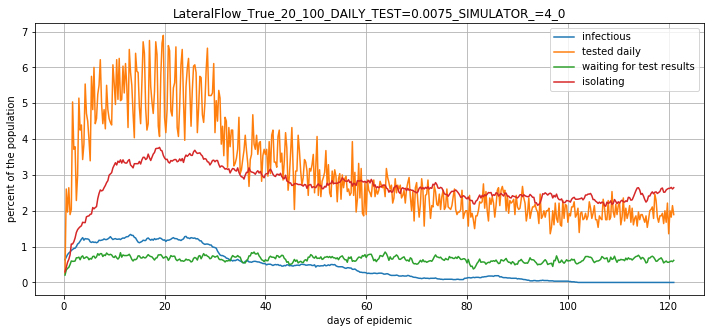

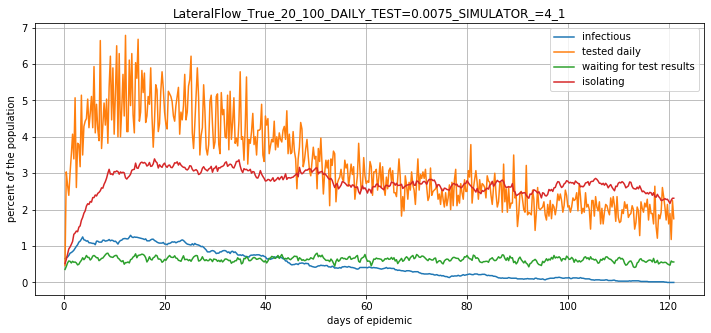

In [38]:
name = "LateralFlow_True_20_100_DAILY_TEST=0.0075_SIMULATOR_=4"
for i in range(2):
    o = results[name][i]
    o.plot(title = name + "_" + str(i))
    print(o.realized_r0)